In [1]:
#### Reference paper https://arxiv.org/abs/1808.08219

#### Keeping tau_i fixed and then calculating y_i as per the value of 
#### tau_i.


import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import fsolve
from adaptive_integrator import integrate
plt.rcParams.update({
  "text.usetex": True,
  "font.family": "serif"
})


# Reference paper https://arxiv.org/abs/1808.08219
# Referencing from Eq.(3.2) to Eq.(3.7) in https://arxiv.org/abs/1808.08219
# Only using the dimensionless equations
# Using PBH as the sole source og Gravitational potential
# Explicitly adding Hubble expansion (or deceleration term) in RD with H(t)=1/2t
# so that v_i = H r_i .
# Using either solve_ivp or adaptive integrator as the differential equation solver


π = np.pi
Ω_cdm = 0.85
G = 6.67e-11                # in units of m^3⋅kg^−1⋅s^−2
t_i = 2.358e5                # in units of seconds
t_eq = 1.5923e12            # in units of seconds
ρ_eq = 2.1548e-16          # in units of kg m^-3
M_solar = 1.989e30        # in units of kg
c = 3e8                 #in units of m/s
A = 1.495e11                 # Astronomical unit
pc = 3.085e16               # in unist of meter. 
yr = 3.154e7              # in units of seconds
a_eq = 2.9374e-4

hbar = 1.0545718e-34        # reduced Planck constant in unkits of J.s
eV = 1.60218e-19               #in units of J
eV_to_kg = 1.7826e-36             #in units of kg
m_FDM_eV = 1e-22     #in units of eV/c²
m_FDM = m_FDM_eV * eV_to_kg      # Mass of FDM boson in units of kg


 
def j_fdm(t, y):
    r, dydtau = y
    dydtau2 = (2*gamma - (gamma**2))/(4*(r**3)) - 1/(r**2) - r/(4 * (t**2))
    return [dydtau, dydtau2]



def j_cdm(t, y):
    r, dydtau = y
    dydtau2 =  - 1/(r**2) - r/(4 * (t**2))
    return [dydtau, dydtau2]


# Full analytic turnaround radius
def r_turnaround_full(tau, gamma): 
    def expression(y_ta):
        return (y_ta**4) - (8 * y_ta * (tau**2)) + ((2 * gamma - gamma**2) * (tau**2))
    r_ta_initial = (8 * (tau**2))**(1/3) 
    return fsolve(expression, r_ta_initial, xtol=1e-10)[0]


# Event function for maximum (dy/dtau = 0)
def event_y_max(t, y):
    return y[1]  # Detect when velocity (dy/dtau) is zero
event_y_max.terminal = False  # Do not stop integration here
event_y_max.direction = -1    # Detect decreasing slope (peak reached)
# Event function for minimum (dy/dtau = 0 after y_max)
def event_y_min(t, y):
    return y[1]  # Detect when velocity (dy/dtau) is zero
event_y_min.terminal = True   # Stop integration here
event_y_min.direction = 1     # Detect increasing slope (trough reached)

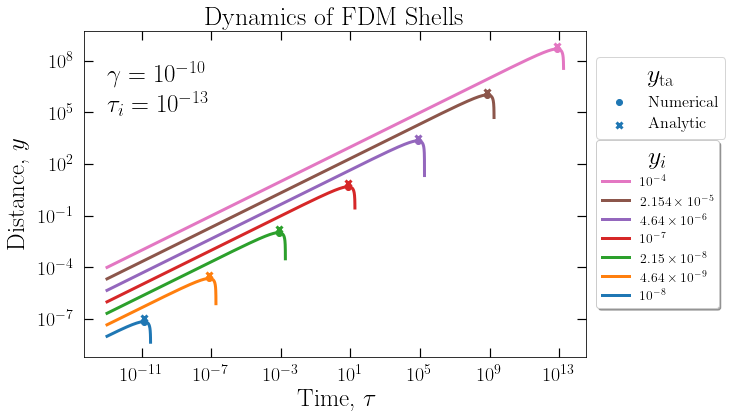

In [2]:
gamma = 1e-10
tau_f = 1e15
yi_arr = np.geomspace(1e-4, 1e-8, 7)


fig, ax = plt.subplots(1, figsize = (9, 6))
plt.rc('lines', linewidth = 3)
plt.rcParams['font.family'] = 'serif'
plt.tick_params(axis='both', right=True, top=True, which='minor', width=1.2, length=4, direction='in')
plt.tick_params(axis='both', right=True, top=True, which='major', width=1.2, length=9, direction='in')

colors = ['C6', 'C5', 'C4', 'C3', 'C2', 'C1', 'C0']
marker_handles = []
for i, (y_i, color) in enumerate(zip(yi_arr, colors)):
    tau_i = 1e-13
    v_i = y_i / (2 * tau_i) 
    y0 = [y_i, v_i]
    tau_arr = np.geomspace(tau_i, tau_f, 10000) 

    
    sol_fdm = solve_ivp(j_fdm, [tau_i, tau_f], y0, t_eval=tau_arr, method='RK45',
        rtol=1e-8, atol=1e-8, events=[event_y_max, event_y_min])

    
    ax.loglog(sol_fdm.t, sol_fdm.y[0], color=color, label=f'FDM $y_i={y_i:.1e}$')

    
    if len(sol_fdm.t_events[0]) > 0: 
        tauta_numerical = sol_fdm.t_events[0][0]
        yta_numerical = sol_fdm.y_events[0][0][0]
        yta_analytic = r_turnaround_full(tauta_numerical, gamma)

        
        yta_numerical_marker = ax.scatter(tauta_numerical, yta_numerical,color=color, zorder=5)
        yta_analytic_marker = ax.scatter(tauta_numerical, yta_analytic, color=color,  marker='x', zorder=5)
        if i == 6:
            marker_handles.append((yta_numerical_marker, "Numerical "))
            marker_handles.append((yta_analytic_marker, "Analytic"))

if len(marker_handles) == 2:  
    legend1 = plt.legend(
        handles=[marker_handles[0][0], marker_handles[1][0]],
        labels=[marker_handles[0][1], marker_handles[1][1]],prop={'size':16.2},
        loc=(1.02, 0.67), title=r'$y_\mathrm{ta}$', title_fontsize= 26, fontsize=12)
    ax.add_artist(legend1)


lines = ax.get_lines()
legend2 = plt.legend([lines[i] for i in range(0, len(colors))], [
        r'$10^{-4}$', r'$2.154\times10^{-5}$', r'$4.64\times10^{-6}$', r'$10^{-7}$',
        r'$2.15\times10^{-8}$', r'$4.64\times10^{-9}$', r'$10^{-8}$'],prop={'size':13.7}, loc=(1.02, 0.15), shadow=True, title='$y_{i}$', title_fontsize=26,
    facecolor='white', fontsize=12)

ax.tick_params(axis='x', pad = 9.9)
ax.tick_params(axis='y', pad = 9.9)


plt.text(tau_i, 5e6, r'$\gamma = 10^{-10}$', fontsize = 25)
plt.text(tau_i, 1e5, r'$\tau_i = 10^{-13}$', fontsize = 25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel(r'Time, $\tau$', fontsize=25)
plt.ylabel('Distance, $y$', fontsize=25, labelpad=9)
plt.title(r' Dynamics of FDM Shells', fontsize= 26)
plt.savefig('diffshells.pdf', bbox_inches='tight')
plt.show()

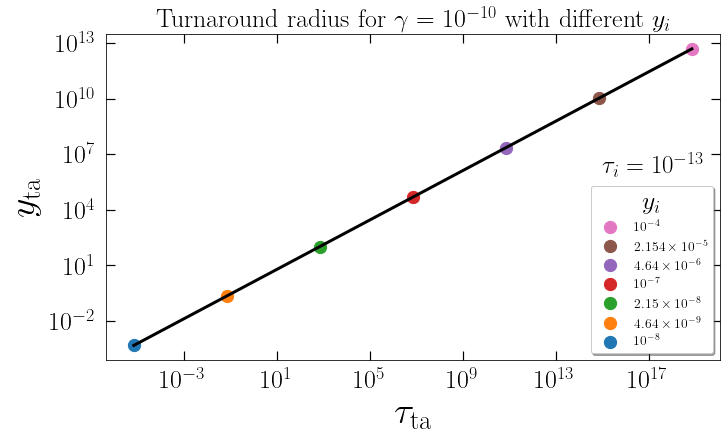

In [3]:
fig, ax = plt.subplots(1, figsize = (11, 6))
plt.rc('lines', linewidth = 3)
plt.rcParams['font.family'] = 'serif'
plt.tick_params(axis='both', right=True, top=True, which='minor', width=1.2, length=4, direction='in')
plt.tick_params(axis='both', right=True, top=True, which='major', width=1.2, length=9, direction='in')




turnaround_points = []
gamma = 1e-10
tau_f = 1e20
yi_arr = np.geomspace(1e-4, 1e-8, 7)

for y_i, color in zip(yi_arr, colors):
    tau_i = 1e-15  
    v_i = y_i / (2 * tau_i)
    y0 = [y_i, v_i]
    tau_arr = np.geomspace(tau_i, tau_f, 10000)

    sol_fdm = solve_ivp(j_fdm, [tau_i, tau_f], y0, t_eval=tau_arr, method='RK45',
        rtol=1e-6, atol=1e-6, events=[event_y_max])

   
    if len(sol_fdm.t_events[0]) > 0: 
        tauta_numerical = sol_fdm.t_events[0][0]
        yta_numerical = sol_fdm.y_events[0][0][0]
        #yta_analytic = r_turnaround_full(tauta_numerical, gamma)
        turnaround_points.append((tauta_numerical, yta_numerical))
        ax.scatter(tauta_numerical, yta_numerical, color=color, s = 150, label=f"$y_i={y_i:.1e}$")



tau_ta_arr, y_ta_arr = zip(*turnaround_points)
ax.loglog(tau_ta_arr, y_ta_arr, color = 'k')

ax.tick_params(axis='x', pad = 9.9)
ax.tick_params(axis='y', pad = 9.9)
    
#plt.text(1e15, 8e6, r'$\gamma = 10^{-10}$', fontsize = 25)
plt.text(1e15, 1e6, r'$\tau_i = 10^{-13}$', fontsize = 25)
plt.xticks(fontsize = 26)
plt.yticks(fontsize = 26)
plt.xlabel(r'$\tau_\mathrm{ta}$', fontsize = 38)
plt.ylabel(r'$y_\mathrm{ta}$', fontsize = 38, labelpad=9)
plt.legend([r'$10^{-4}$', r'$2.154\times10^{-5}$', r'$4.64\times10^{-6}$', r'$10^{-7}$',
        r'$2.15\times10^{-8}$', r'$4.64\times10^{-9}$', r'$10^{-8}$'],
    prop={'size':13.7}, loc='lower right', shadow=True, title='$y_{i}$', title_fontsize=26,
    facecolor='white', fontsize=12)
#plt.title(r' Turnaround radius of FDM Shells with different $y_i$', fontsize = 26)
plt.title(r' Turnaround radius for $\gamma =10^{-10}$ with different $y_i$', fontsize = 26)
plt.savefig('yta_diffshells.pdf', bbox_inches='tight')
plt.show()

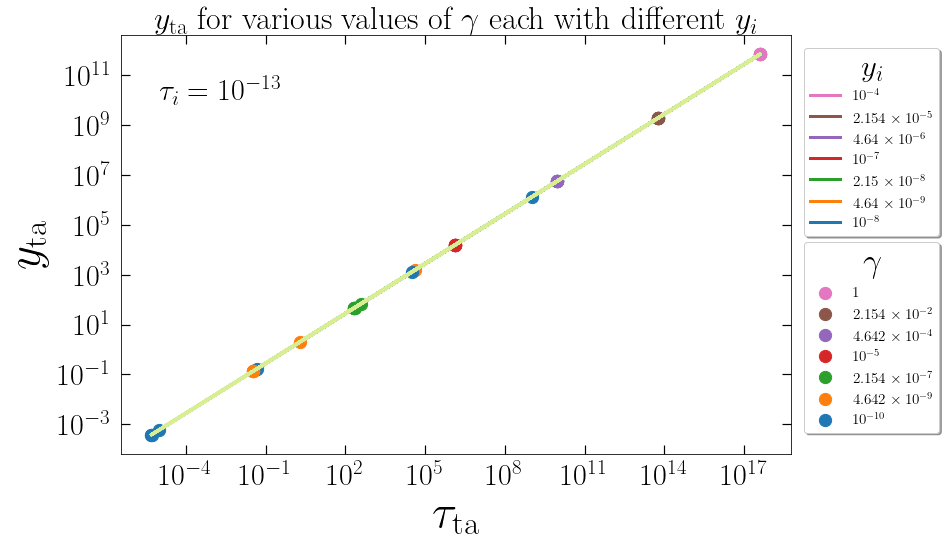

In [4]:
fig, ax = plt.subplots(1, figsize = (12, 7.7))
plt.rc('lines', linewidth = 3.2)
plt.rcParams['font.family'] = 'serif'
plt.tick_params(axis='both', right=True, top=True, which='minor', width=1.2, length=4, direction='in')
plt.tick_params(axis='both', right=True, top=True, which='major', width=1.2, length=9, direction='in')




turnaround_points = []
tau_f = 1e20
yi_arr = np.geomspace(1e-4, 1e-8, 7)
gamma_arr = np.geomspace(1, 1e-10, 7)


colors = ['C6', 'C5', 'C4', 'C3', 'C2', 'C1', 'C0']
colors1_arr = ['#001845', '#184e77', '#1e6091', '#168aad', '#52b69a', '#99d98c', '#d9ed92']

for gamma, color1 in zip(gamma_arr, colors1_arr):
    for y_i, color in zip(yi_arr, colors):
        tau_i = 1e-15  
        v_i = y_i / (2 * tau_i)
        y0 = [y_i, v_i]
        tau_arr = np.geomspace(tau_i, tau_f, 100)

        sol_fdm = solve_ivp(j_fdm, [tau_i, tau_f], y0, t_eval=tau_arr, method='RK45',
            rtol=1e-2, atol=1e-2, events=[event_y_max])


        if len(sol_fdm.t_events[0]) > 0: 
            tauta_numerical = sol_fdm.t_events[0][0]
            yta_numerical = sol_fdm.y_events[0][0][0]
            #yta_analytic = r_turnaround_full(tauta_numerical, gamma)
            turnaround_points.append((tauta_numerical, yta_numerical))
            ax.scatter(tauta_numerical, yta_numerical, color=color, s = 150)



    tau_ta_arr, y_ta_arr = zip(*turnaround_points)
    ax.loglog(tau_ta_arr, y_ta_arr, color = color1, label=f"$\gamma ={gamma:.1e}$")
    legend1 = plt.legend(
    [lines[i] for i in range(0, len(colors))], [
        r'$10^{-4}$', r'$2.154\times10^{-5}$', r'$4.64\times10^{-6}$', r'$10^{-7}$',
        r'$2.15\times10^{-8}$', r'$4.64\times10^{-9}$', r'$10^{-8}$'
    ],
    prop={'size':15.2}, loc=(1.02, 0.52), shadow=True, title='$y_{i}$', title_fontsize=31,
    facecolor='white', fontsize=12)
    
plt.text(1e-5, 1e10, r'$\tau_i = 10^{-13}$', fontsize = 30)

ax.tick_params(axis='x', pad = 9.9)
ax.tick_params(axis='y', pad = 9.9)


plt.xticks(fontsize = 30)
plt.yticks(fontsize = 30)
plt.xlabel(r'$\tau_\mathrm{ta}$', fontsize = 47)
plt.ylabel(r'$y_\mathrm{ta}$', fontsize = 47, labelpad=9)


plt.legend( [r'$1$', r'$2.154\times10^{-2}$',  r'$4.642\times10^{-4}$', r'$10^{-5}$', r'$2.154\times10^{-7}$',
    r'$ 4.642\times10^{-9}$', r'$10^{-10}$'],prop = {'size':15.2}, loc = (1.02, 0.05),shadow = True, title = '$\gamma$' ,title_fontsize = 34,
           facecolor = 'white',fontsize = 25)

ax.add_artist(legend1)
plt.title(r'$y_\mathrm{ta}$ for various values of $\gamma$ each with different $y_i$', fontsize = 32)
plt.savefig('yta_diffshellsdiffgamma.pdf', bbox_inches='tight')
plt.show()